In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from dm21cm.utils import load_h5_dict, save_h5_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [2]:
ps_m_data = load_h5_dict(f"../../data/pwave/m_data.h5")

In [5]:
m_range = ps_m_data['m_range']
z_range = ps_m_data['z_range']
ann_rates = ps_m_data['annihilation_rates']
dNdM_ps = ps_m_data['dNdM']
dNdM_st = ps_m_data['dNdM_ST']
print(m_range.shape)
print(z_range.shape)
print(ann_rates.shape)
print(dNdM_ps.shape)
print(dNdM_st.shape)

(4001,)
(51,)
(51, 4001)
(51, 4001)
(51, 4001)


In [6]:
box_len = 2 * u.Mpc
mbox = (cosmo.Om0 * cosmo.critical_density0 * box_len**3).to('M_sun').value
print(np.log10(mbox))

11.497959389586754


In [7]:
def color_z(z):
    zmax = np.max(z_range)
    zmin = np.min(z_range)
    return mpl.colormaps['plasma'](1 - (z - zmin) / (zmax - zmin))

# Halo counts

In [8]:
for i_z in [0, 1, 2, 3, 4, 5, 6, 8, 10, 15, 20]:
    z = z_range[i_z]
    volume = 2**3 # [Mpc^3]
    m_threshold = mbox
    print(f"z = {z:6.2f}", end=' ')
    print(f'PS: {np.trapz(dNdM_ps[i_z] * (m_range >= m_threshold), m_range) * volume:.6f}', end=' ')
    print(f'ST: {np.trapz(dNdM_st[i_z] * (m_range >= m_threshold), m_range) * volume:.6f}', end=' ')
    print()

z =   0.00 PS: 0.062680 ST: 0.044467 
z =   1.00 PS: 0.062921 ST: 0.046372 
z =   2.00 PS: 0.040600 ST: 0.034543 
z =   3.00 PS: 0.018022 ST: 0.019315 
z =   4.00 PS: 0.005808 ST: 0.008465 
z =   5.00 PS: 0.001398 ST: 0.002978 
z =   6.00 PS: 0.000255 ST: 0.000852 
z =   8.00 PS: 0.000004 ST: 0.000039 
z =  10.00 PS: 0.000000 ST: 0.000001 
z =  15.00 PS: 0.000000 ST: 0.000000 
z =  20.00 PS: 0.000000 ST: 0.000000 


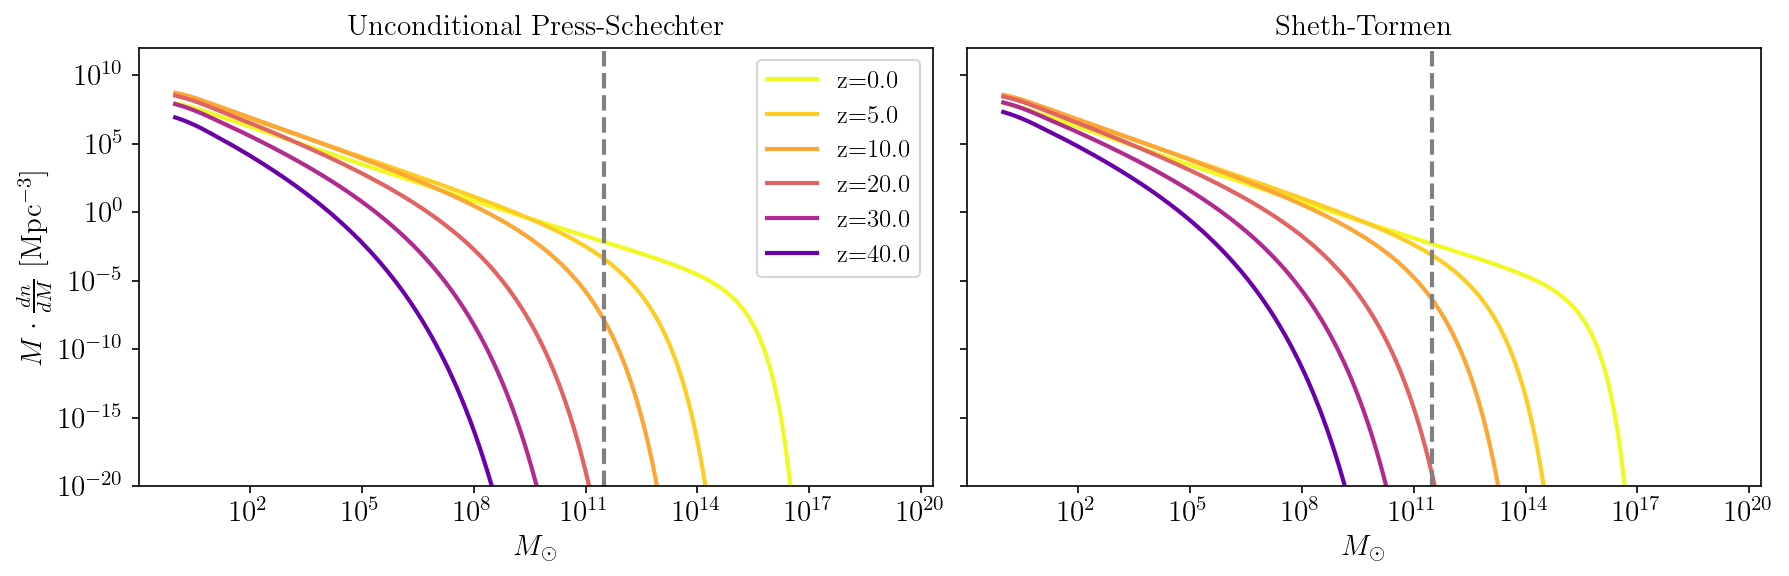

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

for i_z in [0, 5, 10, 20, 30, 40]:
    z = z_range[i_z]
    for j, dNdM in enumerate([dNdM_ps, dNdM_st]):
        axs[j].plot(m_range, m_range * dNdM[i_z], label=f'z={z}', color=color_z(z))

for i in range(2):
    axs[i].axvline(mbox, color='gray', ls='--')

axs[0].set(xscale='log', yscale='log', ylim=(1e-20, 1e12))
axs[0].set(xlabel='$M_\odot$', ylabel=r'$M\cdot\frac{dn}{dM}$ [Mpc$^{-3}$]', title='Unconditional Press-Schechter')
axs[0].legend()
axs[1].set(xscale='log', yscale='log', ylim=(1e-20, 1e12))
axs[1].set(xlabel='$M_\odot$', title='Sheth-Tormen')

fig.tight_layout()

In [8]:
r_ps_s = []
r_st_s = []
r_ps_s2 = []
r_st_s2 = []
for i_z in range(len(z_range)):
    z = z_range[i_z]
    m_threshold = (cosmo.Om0 * cosmo.critical_density0 * box_len**3).to('M_sun').value
    r_ps_s.append(np.trapz(ann_rates[i_z] * dNdM_ps[i_z] * (m_range >= m_threshold), m_range) * volume)
    r_st_s.append(np.trapz(ann_rates[i_z] * dNdM_st[i_z] * (m_range >= m_threshold), m_range) * volume)
    m_threshold = 0.
    r_ps_s2.append(np.trapz(ann_rates[i_z] * dNdM_ps[i_z] * (m_range >= m_threshold), m_range) * volume)
    r_st_s2.append(np.trapz(ann_rates[i_z] * dNdM_st[i_z] * (m_range >= m_threshold), m_range) * volume)

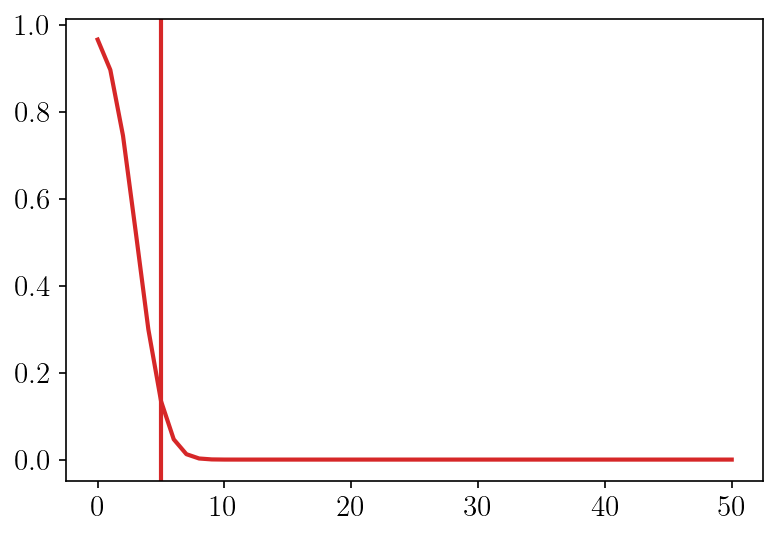

In [9]:
plt.plot(z_range, np.array(r_ps_s)/np.array(r_ps_s2), label='PS')
plt.axvline(5)

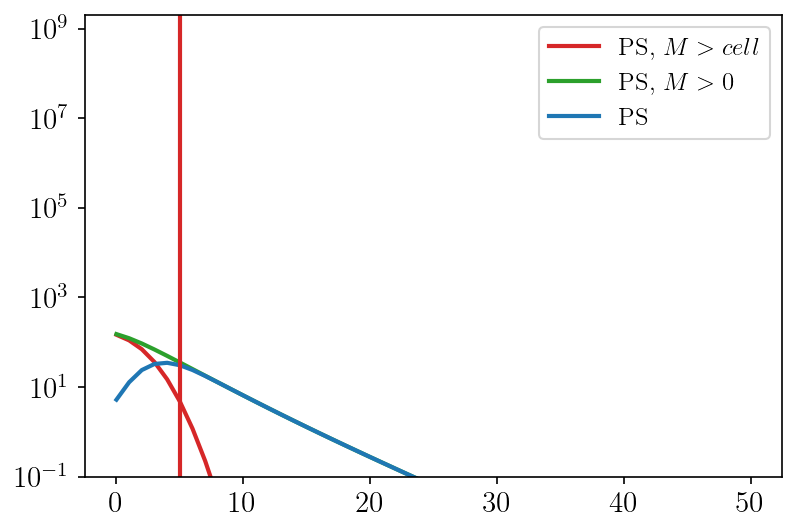

In [35]:
plt.plot(z_range, r_ps_s, label='PS, $M > cell$')
# plt.plot([0, 5, 10, 20, 30, 40], r_st_s, label='ST, $M > cell$')
plt.plot(z_range, r_ps_s2, label='PS, $M > 0$')
plt.plot(z_range, np.array(r_ps_s2)-np.array(r_ps_s), label='PS')
# plt.plot([0, 5, 10, 20, 30, 40], r_st_s2, label='ST, $M > 0$')
plt.axvline(5)
plt.yscale('log')
plt.ylim(1e-1, None)
plt.legend()

# Halo contribution v. mass

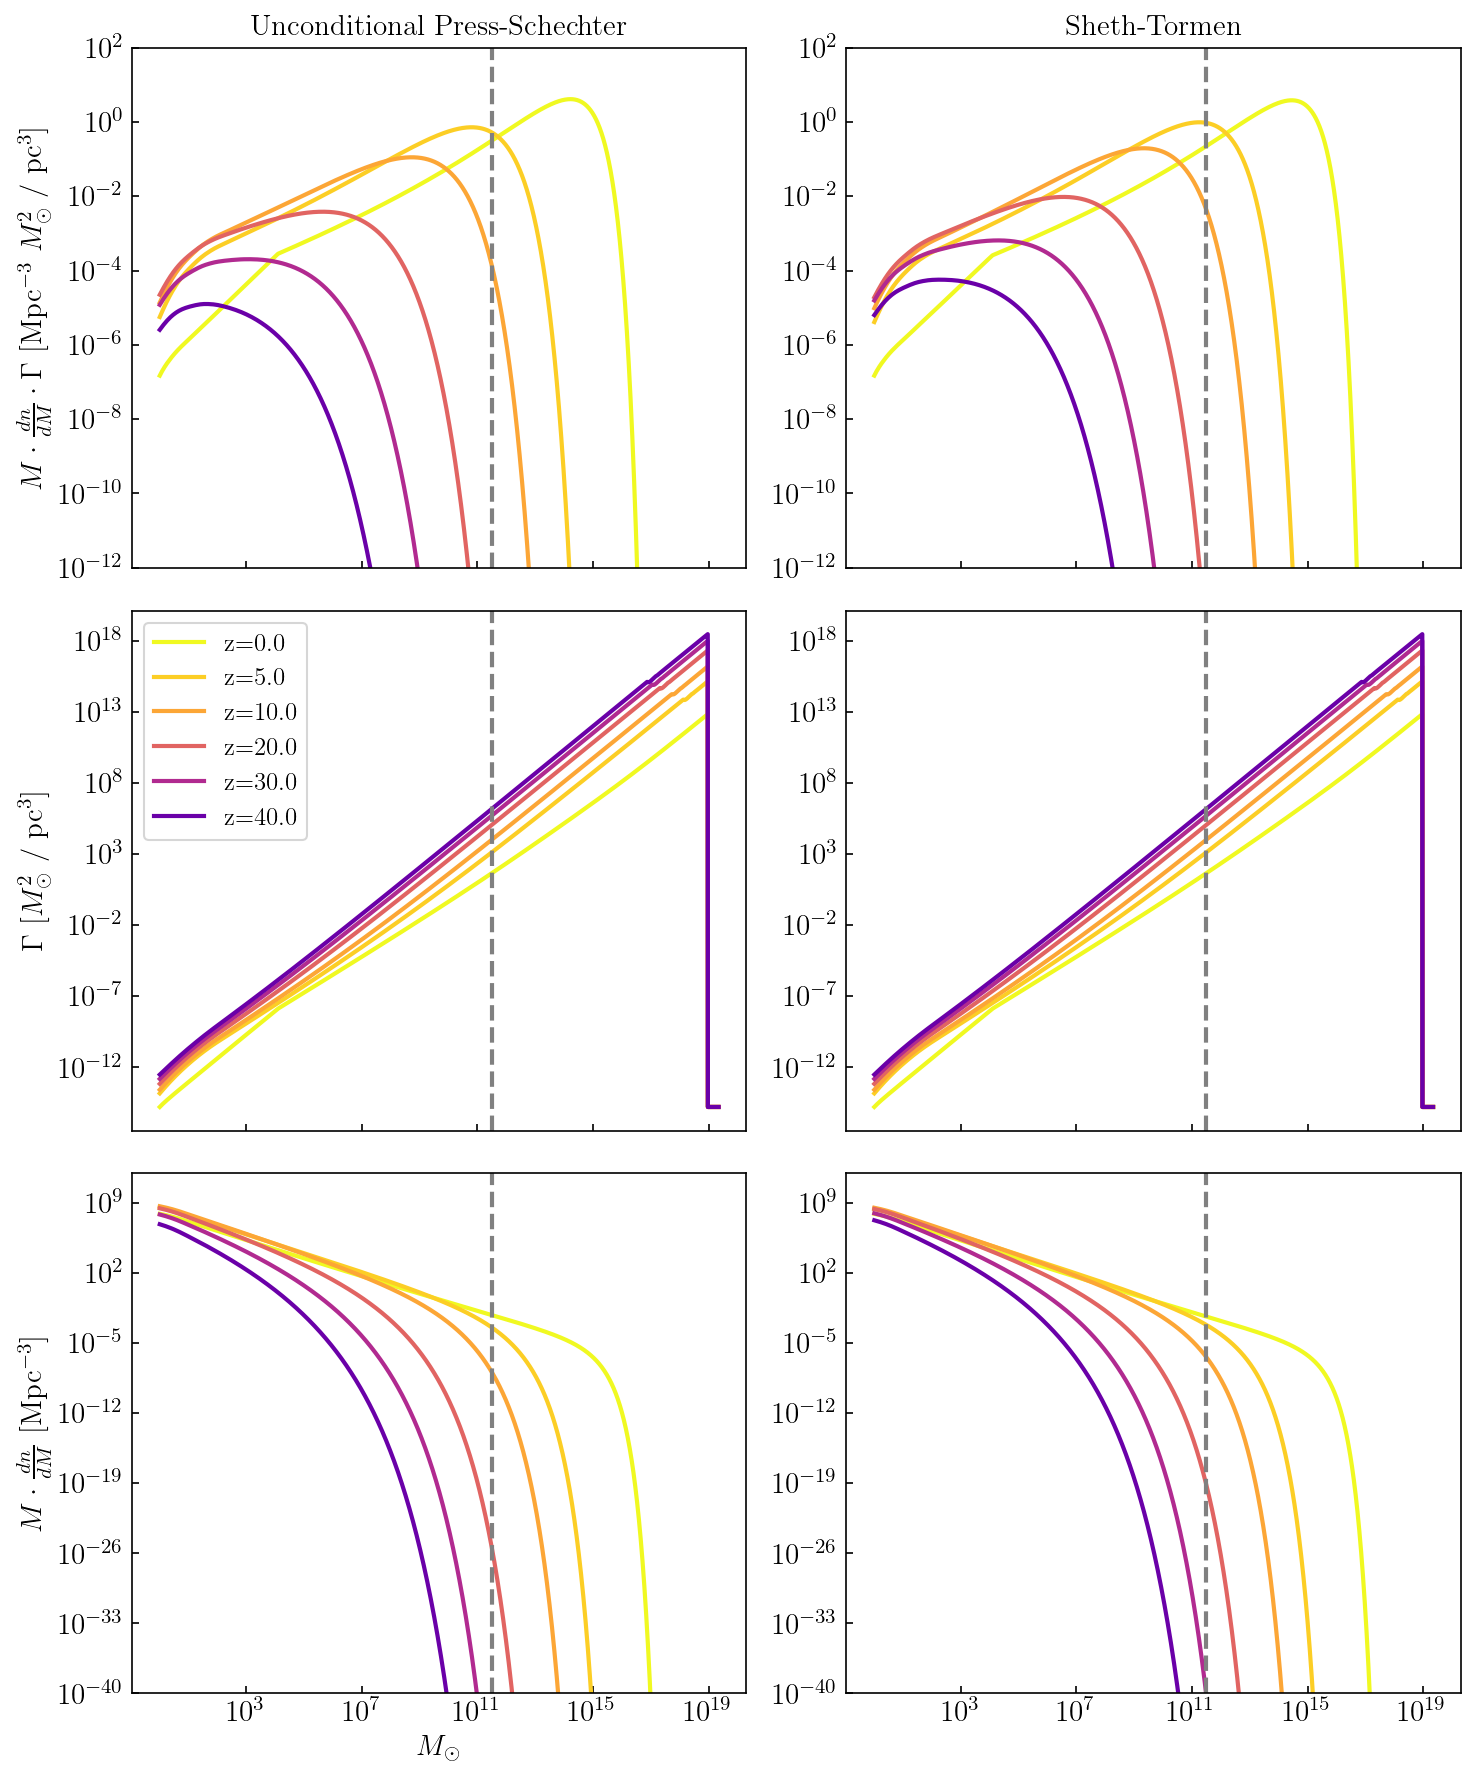

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex=True)

for i in range(3):
    for j in range(1, 2):
        axs[i, j].sharey(axs[i, 0])

for i_z in [0, 5, 10, 20, 30, 40]:
    z = z_range[i_z]
    for j, dNdM in enumerate([dNdM_ps, dNdM_st]):
        axs[0,j].plot(m_range, m_range * dNdM[i_z] * ann_rates[i_z], label=f'z={z}', color=color_z(z))
        axs[1,j].plot(m_range, ann_rates[i_z], label=f'z={z}', color=color_z(z))
        axs[2,j].plot(m_range, m_range * dNdM[i_z], label=f'z={z}', color=color_z(z))

axs[0,0].set(xscale='log', yscale='log', ylim=(1e-12, 1e2))
axs[0,0].set(ylabel=r'$M\cdot\frac{dn}{dM}\cdot\Gamma$ [Mpc$^{-3}$ $M_\odot^2$ / pc$^3$]')
axs[1,0].set(xscale='log', yscale='log', ylim=(None, None))
axs[1,0].set(ylabel=r'$\Gamma$ [$M_\odot^2$ / pc$^3$]')
axs[2,0].set(xscale='log', yscale='log', ylim=(1e-40, 1e12))
axs[2,0].set(xlabel='$M_\odot$', ylabel=r'$M\cdot\frac{dn}{dM}$ [Mpc$^{-3}$]')
axs[1,0].legend()

for i in range(3):
    for j in range(2):
        axs[i,j].axvline(mbox, color='gray', ls='--')

axs[0,0].set(title='Unconditional Press-Schechter')
axs[0,1].set(title='Sheth-Tormen')

fig.tight_layout()

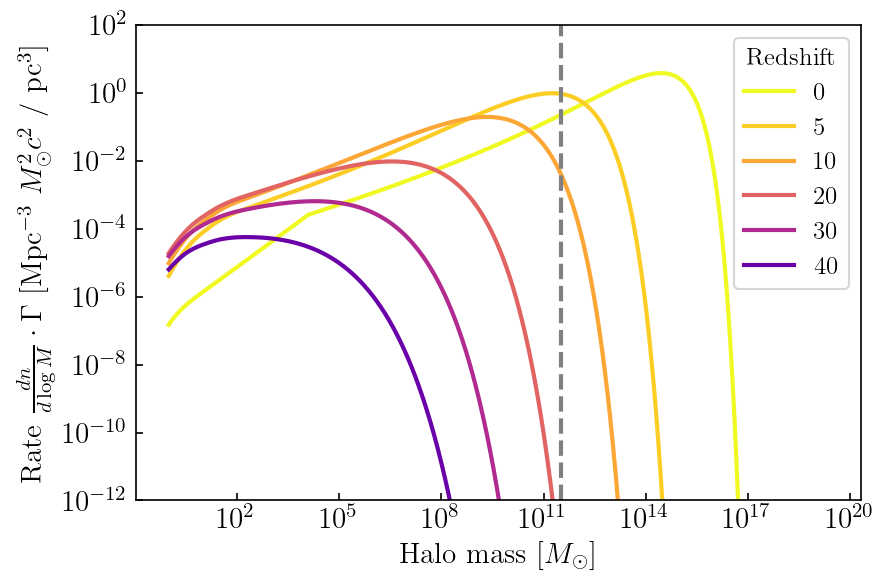

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True)

for i_z in [0, 5, 10, 20, 30, 40]:
    z = z_range[i_z]
    dNdM = dNdM_st
    ax.plot(m_range, m_range * dNdM[i_z] * ann_rates[i_z], label=f'{z:.0f}', color=color_z(z))

ax.set(xscale='log', yscale='log', ylim=(1e-12, 1e2))
ax.set(xlabel=r'Halo mass [$M_\odot$]', ylabel=r'Rate $\frac{dn}{d\log M}\cdot\Gamma$ [Mpc$^{-3}$ $M_\odot^2 c^2$ / pc$^3$]')
ax.axvline(mbox, color='gray', ls='--')
ax.legend(title='Redshift')

fig.tight_layout()
fig.savefig('halo-contributions.pdf')

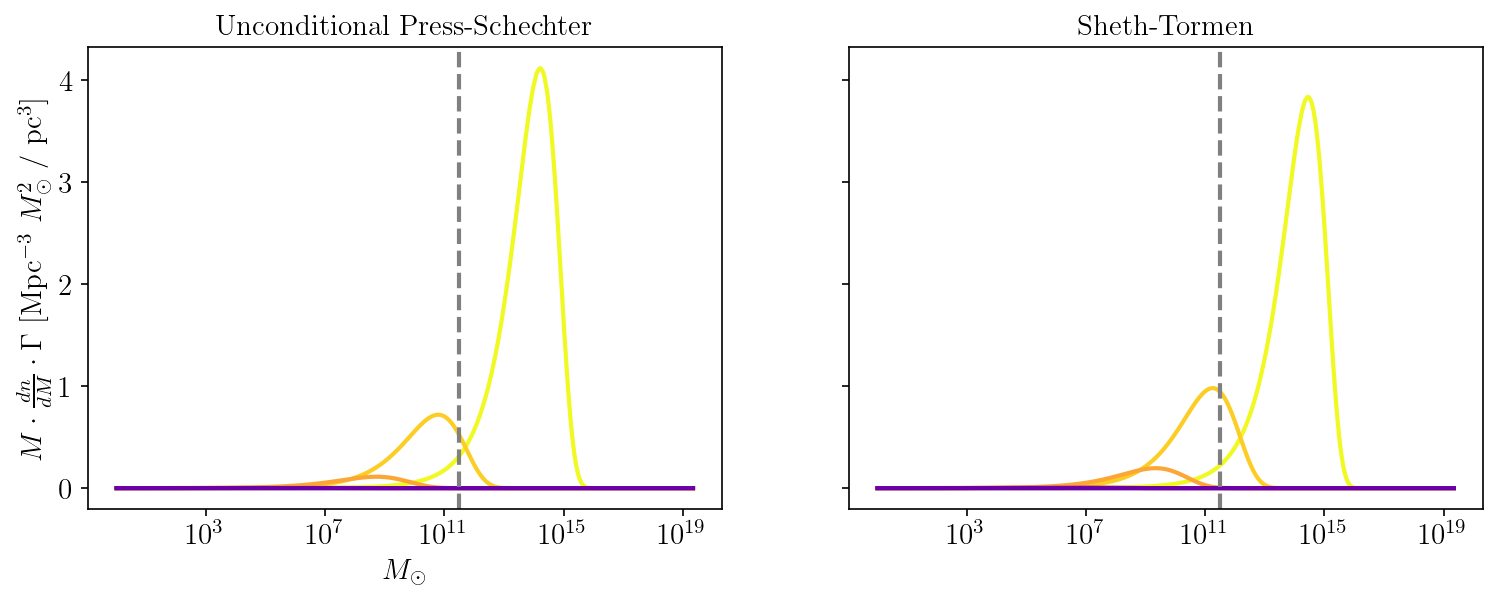

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

for i_z in [0, 5, 10, 20, 30, 40]:
    z = z_range[i_z]
    for j, dNdM in enumerate([dNdM_ps, dNdM_st]):
        axs[j].plot(m_range, m_range * dNdM[i_z] * ann_rates[i_z], label=f'z={z}', color=color_z(z))

axs[0].set(xscale='log')
axs[0].set(xlabel='$M_\odot$', ylabel=r'Relative $M\cdot\frac{dn}{dM}\cdot\Gamma$')


for j in range(2):
    axs[j].axvline(mbox, color='gray', ls='--')

axs[0].set(title='Unconditional Press-Schechter')
axs[1].set(title='Sheth-Tormen');